# 신용카드 사기 탐지 분류 모델 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

In [ ]:
train_df = pd.read_csv('./modulabs-ds5-credit-card-fraud-detection/train.csv')
X_test = pd.read_csv('./modulabs-ds5-credit-card-fraud-detection/test.csv')

display(train_df.info())
display(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

None

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Target distribution:
 Class
0    0.997893
1    0.002107
Name: proportion, dtype: float64


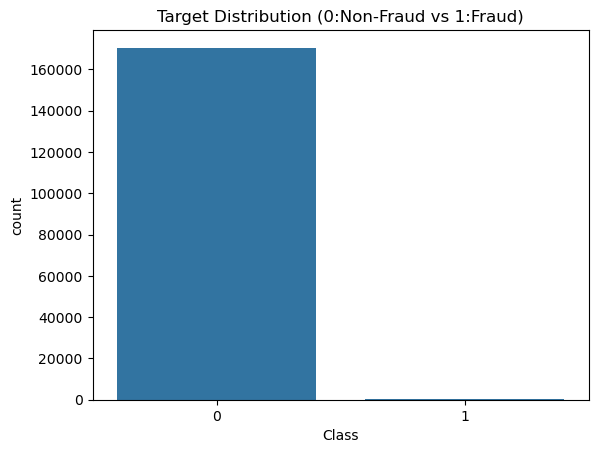

In [3]:
print('Target distribution:\n', train_df['Class'].value_counts(normalize=True))

sns.countplot(x='Class', data=train_df)
plt.title('Target Distribution (0:Non-Fraud vs 1:Fraud)')
plt.show()

In [4]:
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


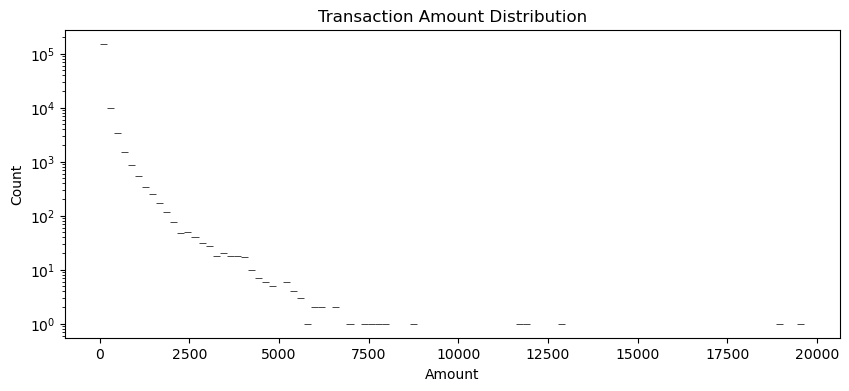

In [5]:
plt.figure(figsize=(10,4))
sns.histplot(train_df['Amount'], bins=100, log_scale=(False, True))
plt.title('Transaction Amount Distribution')
plt.show()

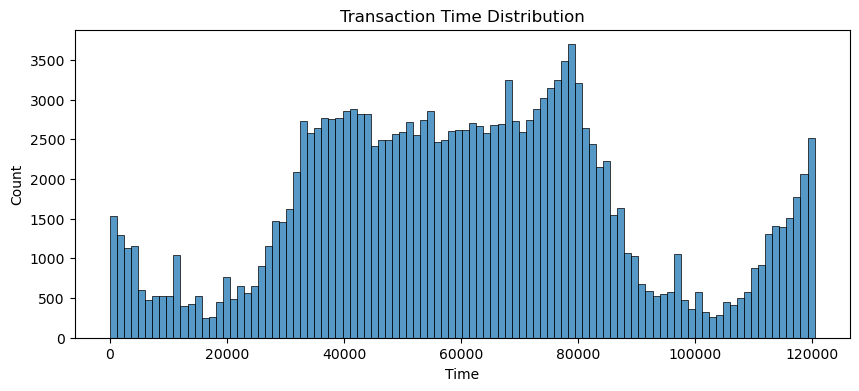

In [6]:
plt.figure(figsize=(10,4))
sns.histplot(train_df['Time'], bins=100)
plt.title('Transaction Time Distribution')
plt.show()

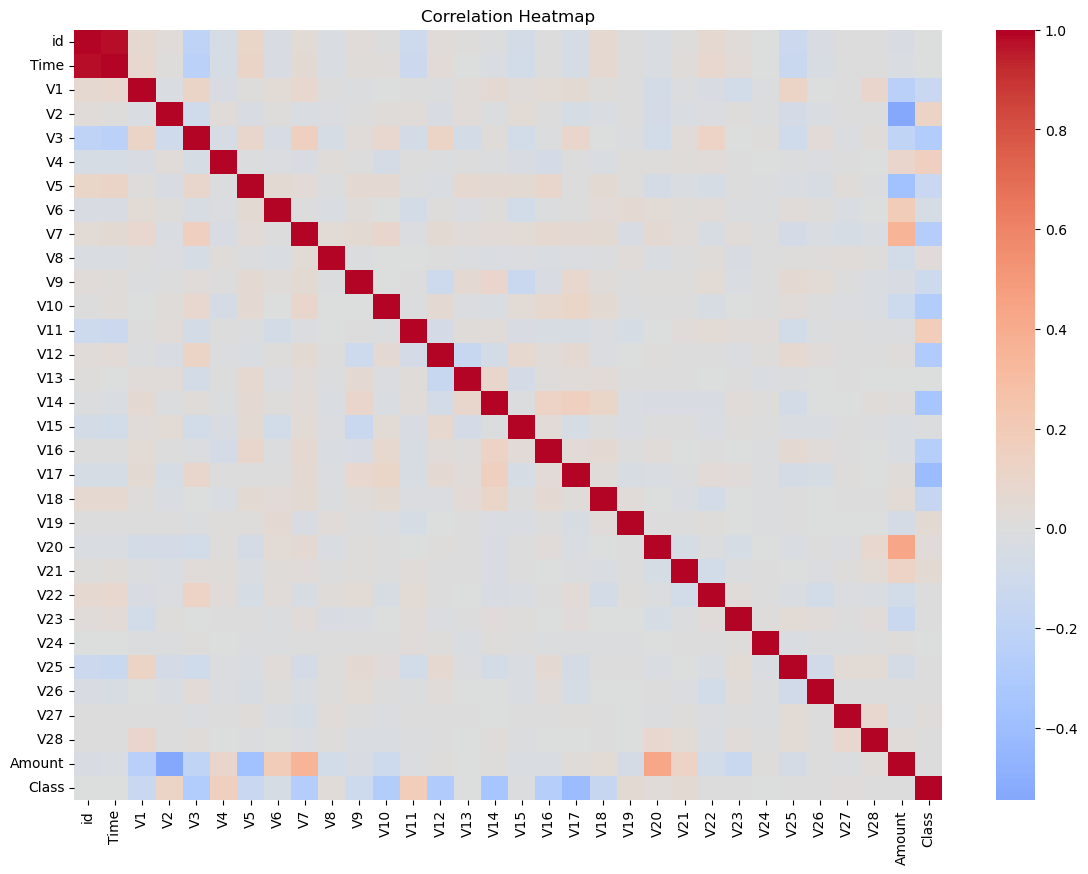

In [7]:
plt.figure(figsize=(14,10))
corr = train_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [8]:
corr['Class'].sort_values(ascending=False).head(15)

Class     1.000000
V11       0.181917
V4        0.159813
V2        0.124537
V21       0.050751
V19       0.048401
V8        0.026687
V20       0.023689
V27       0.021196
V28       0.007481
Amount    0.004528
V22       0.003981
V26       0.002472
V23      -0.001187
V25      -0.001201
Name: Class, dtype: float64

In [9]:
def evaluate_model(name: str, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_va)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X_va)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)  
        y_proba = scores
    else:
        y_proba = model.predict(X_va).astype(float)

    y_pred = (y_proba >= 0.5).astype(int)
    roc  = roc_auc_score(y_va, y_proba)
    prau = average_precision_score(y_va, y_proba)
    f1   = f1_score(y_va, y_pred, zero_division=0)
    cm   = confusion_matrix(y_va, y_pred)

    print(f'\n[{name}] ROC-AUC: {roc:.4f} | PR-AUC: {prau:.4f} | F1: {f1:.4f}')
    print(classification_report(y_va, y_pred, digits=4, zero_division=0))

    return {'name':name, 'roc_auc':roc, 'pr_auc':prau, 'f1':f1, 
            'model':model, 'y_pred':y_pred, 'y_proba':y_proba, 'cm':cm}

def plot_model_summary(y_true, y_pred, y_proba, title_prefix="", roc_auc=None, pr_auc=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax=axes[0], colorbar=False)
    axes[0].set_title('Confusion Matrix')

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    axes[1].plot(fpr, tpr, label='ROC')
    axes[1].plot([0, 1], [0, 1], linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve' + (f'/ AUC={roc_auc:.3f}' if roc_auc is not None else ''))
    axes[1].legend()

    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    axes[2].plot(recall, precision, label='PR')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title(f'PR Curve' + (f'/ AP={pr_auc:.3f}' if pr_auc is not None else ''))
    axes[2].legend()

    fig.suptitle(f'[{title_prefix}]', y=1.05, fontsize=12)
    plt.tight_layout()
    plt.show()

In [10]:
df = train_df.copy()
X = df.drop(columns=['Class','id'], errors='ignore')
y = df['Class'].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
num_features = X.columns.tolist()
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('var_thresh', VarianceThreshold(threshold=0.0))])
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)], remainder='drop')

scaled_pipe = Pipeline([('prep', preprocessor), ('scaler', StandardScaler())])
tree_pipe = Pipeline([('prep', preprocessor)])
bernoulli_pipe = Pipeline([('prep', preprocessor),
                           ('scaler', StandardScaler()),        
                           ('binarize', Binarizer(threshold=0.0))])

pipe_map = {'scaled': scaled_pipe,
            'tree': tree_pipe,
            'bernoulli': bernoulli_pipe}

In [12]:
models = [('LogisticRegression', LogisticRegression(max_iter=1000, class_weight='balanced'), 'scaled'),
          ('LinearSVC', LinearSVC(max_iter=2000, class_weight='balanced'), 'scaled'),
          ('SVC_RBF', SVC(kernel='rbf', class_weight='balanced', probability=True), 'scaled'),
          ('GaussianNB', GaussianNB(), 'scaled'),          
          ('BernoulliNB', BernoulliNB(), 'bernoulli'),     
          ('KNN', KNeighborsClassifier(n_neighbors=5), 'scaled'),
          ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42), 'scaled'),
          ('DecisionTree', DecisionTreeClassifier(class_weight='balanced', random_state=42), 'tree'),
          ('RandomForest', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42), 'tree'),
          ('ExtraTrees', ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=42), 'tree'),
          ('GradientBoosting', GradientBoostingClassifier(random_state=42), 'tree'),
          ('Bagging', BaggingClassifier(random_state=42), 'tree')]


[LogisticRegression] ROC-AUC: 0.9829 | PR-AUC: 0.7398 | F1: 0.1479
              precision    recall  f1-score   support

           0     0.9998    0.9782    0.9889     34105
           1     0.0805    0.9028    0.1479        72

    accuracy                         0.9781     34177
   macro avg     0.5402    0.9405    0.5684     34177
weighted avg     0.9979    0.9781    0.9871     34177



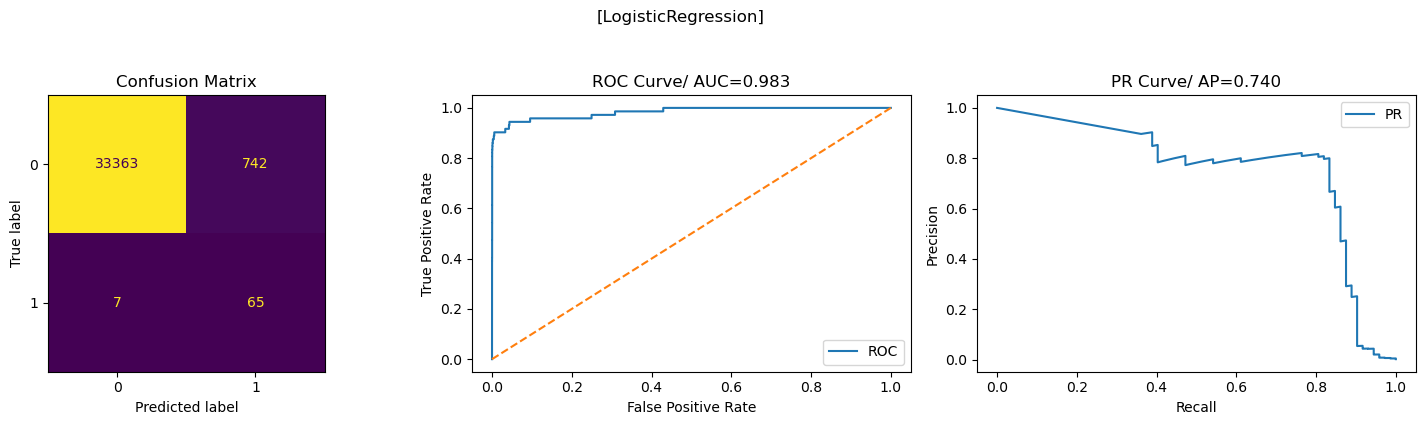

c:\Users\qazsx\miniconda3\envs\ds_study\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\qazsx\miniconda3\envs\ds_study\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



[LinearSVC] ROC-AUC: 0.9545 | PR-AUC: 0.7317 | F1: 0.7176
              precision    recall  f1-score   support

           0     0.9993    0.9996    0.9995     34105
           1     0.7966    0.6528    0.7176        72

    accuracy                         0.9989     34177
   macro avg     0.8979    0.8262    0.8585     34177
weighted avg     0.9988    0.9989    0.9989     34177



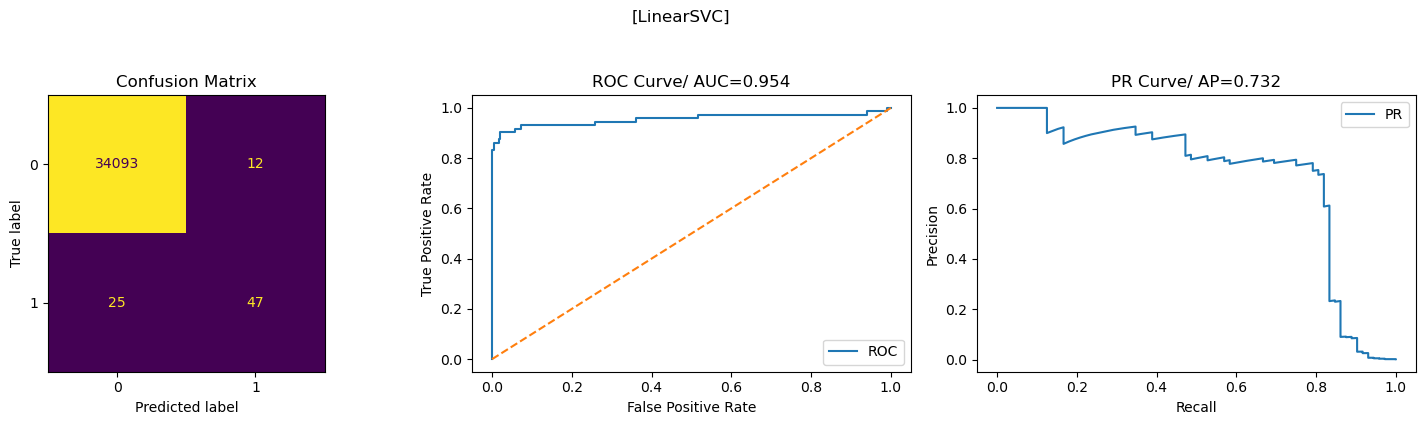


[SVC_RBF] ROC-AUC: 0.9701 | PR-AUC: 0.5940 | F1: 0.5370
              precision    recall  f1-score   support

           0     0.9987    0.9998    0.9993     34105
           1     0.8056    0.4028    0.5370        72

    accuracy                         0.9985     34177
   macro avg     0.9021    0.7013    0.7682     34177
weighted avg     0.9983    0.9985    0.9983     34177



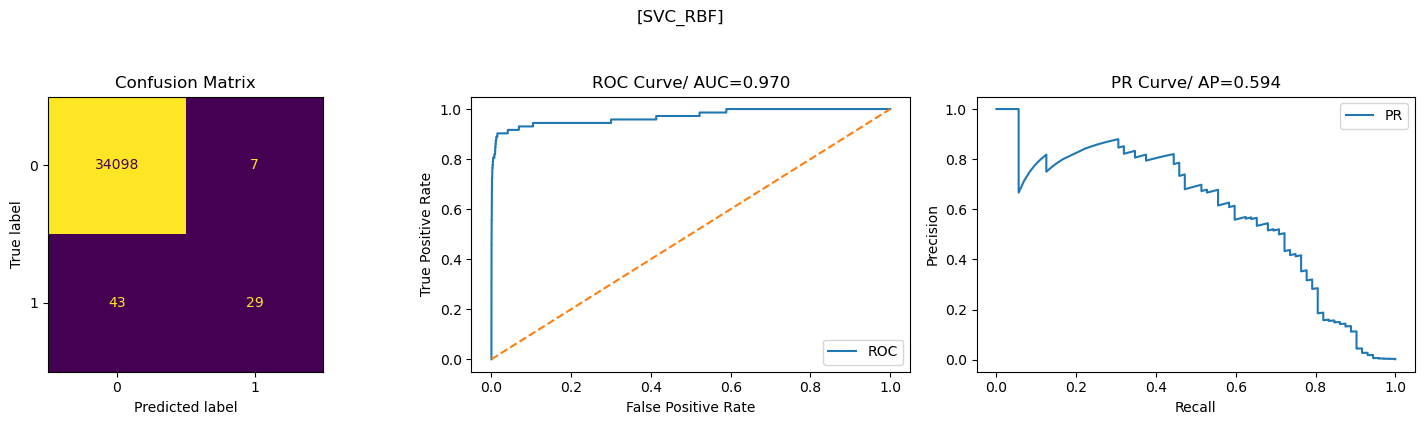


[GaussianNB] ROC-AUC: 0.9578 | PR-AUC: 0.0993 | F1: 0.1302
              precision    recall  f1-score   support

           0     0.9996    0.9768    0.9881     34105
           1     0.0706    0.8333    0.1302        72

    accuracy                         0.9765     34177
   macro avg     0.5351    0.9051    0.5591     34177
weighted avg     0.9977    0.9765    0.9863     34177



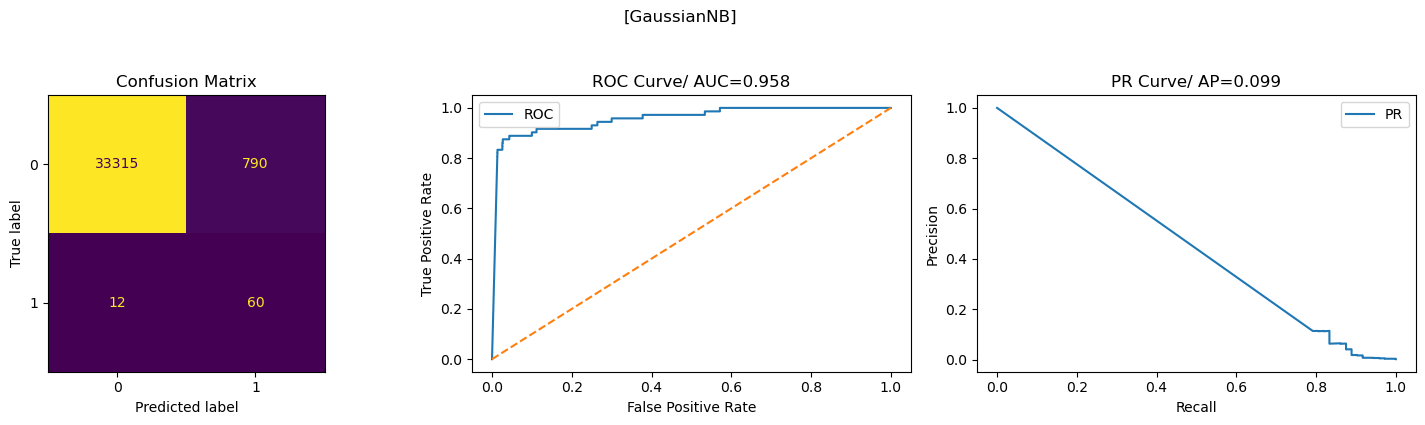


[BernoulliNB] ROC-AUC: 0.9470 | PR-AUC: 0.5798 | F1: 0.7591
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     34105
           1     0.8000    0.7222    0.7591        72

    accuracy                         0.9990     34177
   macro avg     0.8997    0.8609    0.8793     34177
weighted avg     0.9990    0.9990    0.9990     34177



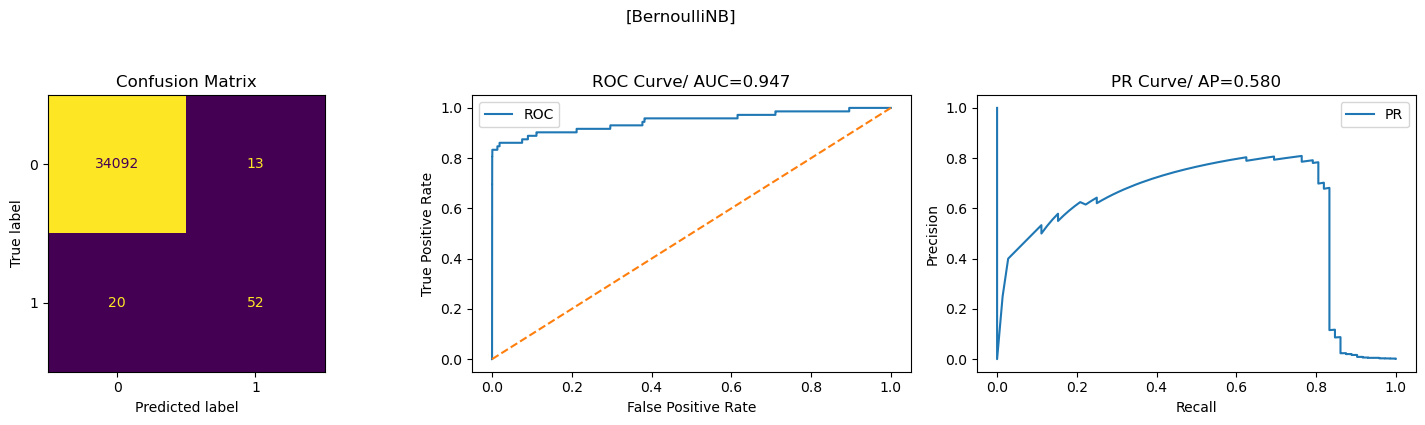


[KNN] ROC-AUC: 0.9374 | PR-AUC: 0.8460 | F1: 0.8550
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     34105
           1     0.9492    0.7778    0.8550        72

    accuracy                         0.9994     34177
   macro avg     0.9743    0.8888    0.9273     34177
weighted avg     0.9994    0.9994    0.9994     34177



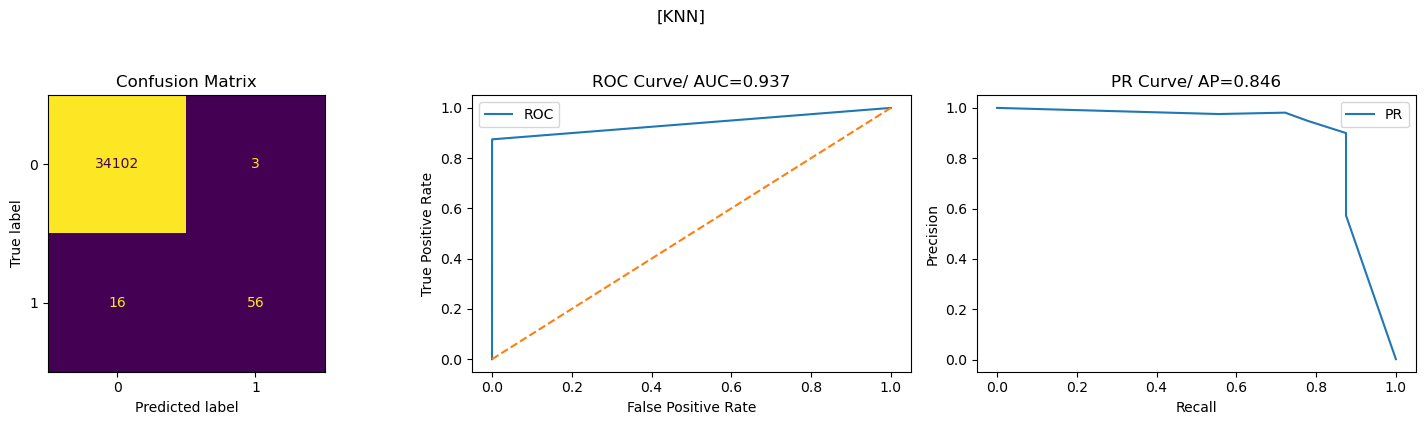


[MLP] ROC-AUC: 0.9882 | PR-AUC: 0.8715 | F1: 0.8615
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     34105
           1     0.9655    0.7778    0.8615        72

    accuracy                         0.9995     34177
   macro avg     0.9825    0.8889    0.9306     34177
weighted avg     0.9995    0.9995    0.9994     34177



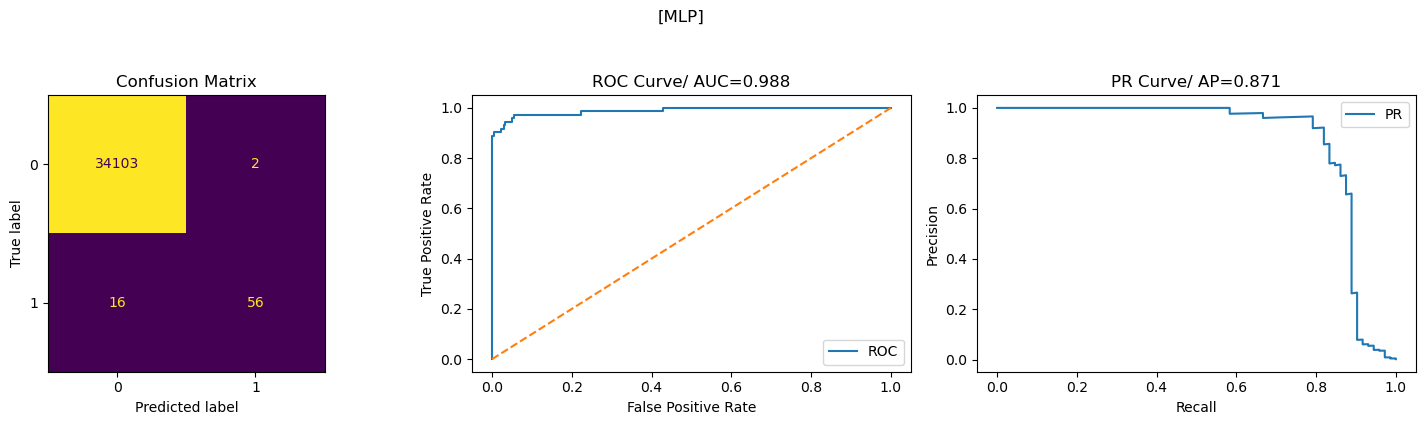


[DecisionTree] ROC-AUC: 0.8677 | PR-AUC: 0.5278 | F1: 0.7260
              precision    recall  f1-score   support

           0     0.9994    0.9994    0.9994     34105
           1     0.7162    0.7361    0.7260        72

    accuracy                         0.9988     34177
   macro avg     0.8578    0.8677    0.8627     34177
weighted avg     0.9988    0.9988    0.9988     34177



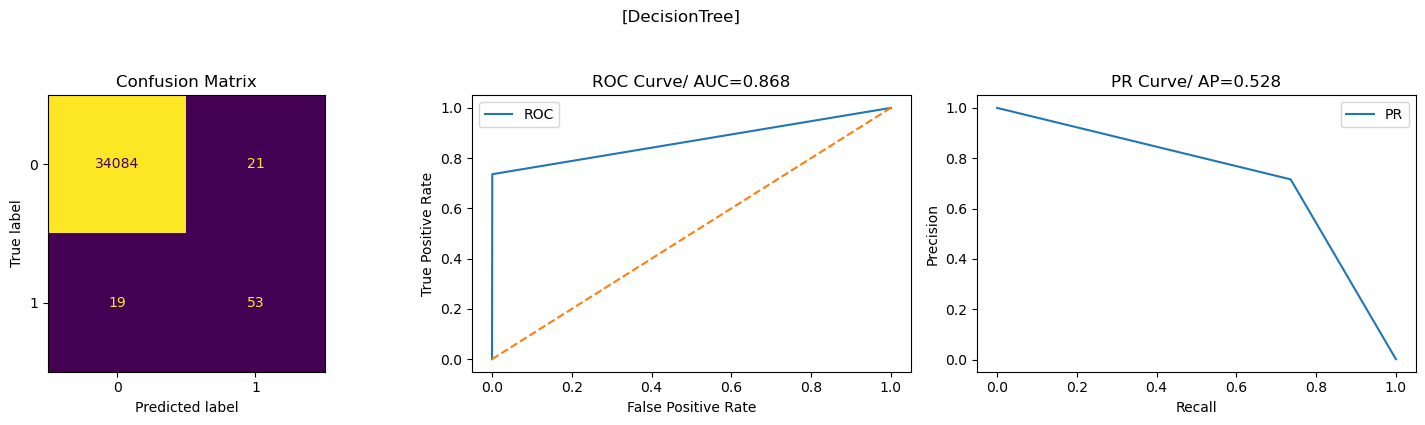


[RandomForest] ROC-AUC: 0.9494 | PR-AUC: 0.8765 | F1: 0.9104
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     34105
           1     0.9839    0.8472    0.9104        72

    accuracy                         0.9996     34177
   macro avg     0.9918    0.9236    0.9551     34177
weighted avg     0.9996    0.9996    0.9996     34177



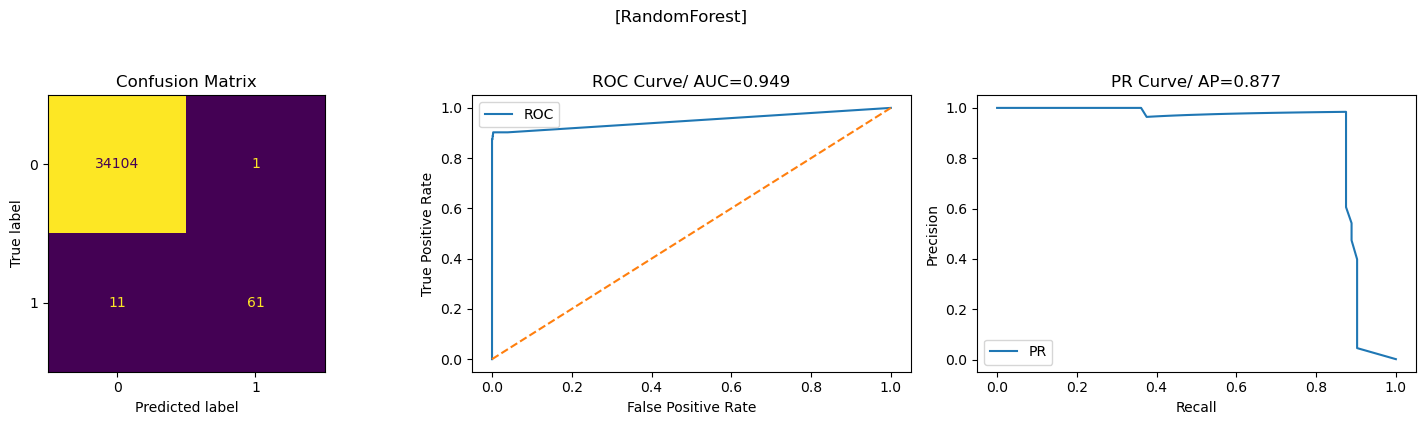


[ExtraTrees] ROC-AUC: 0.9698 | PR-AUC: 0.8838 | F1: 0.9265
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9999     34105
           1     0.9844    0.8750    0.9265        72

    accuracy                         0.9997     34177
   macro avg     0.9921    0.9375    0.9632     34177
weighted avg     0.9997    0.9997    0.9997     34177



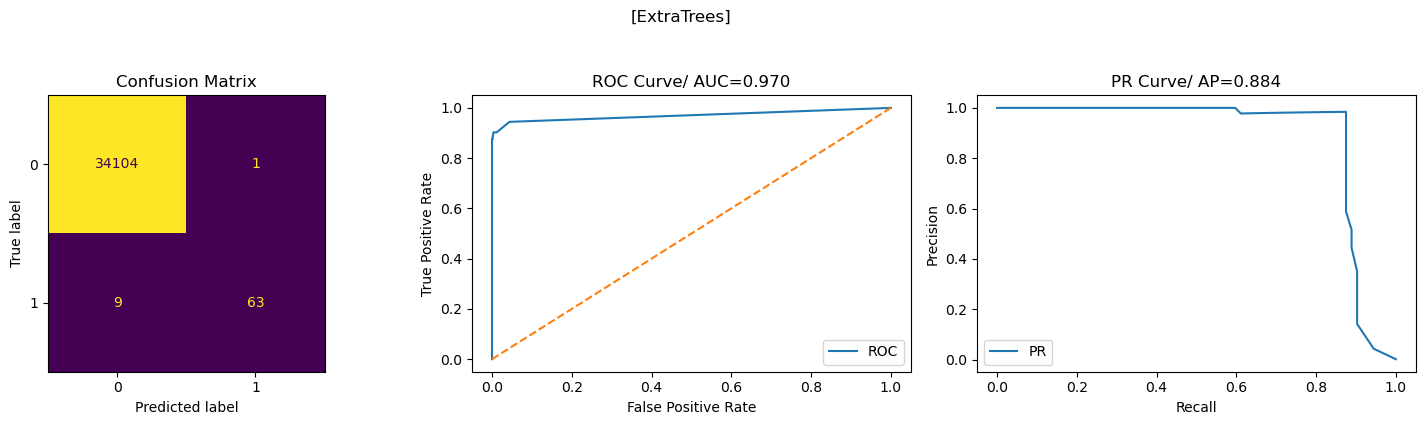


[GradientBoosting] ROC-AUC: 0.9637 | PR-AUC: 0.6433 | F1: 0.7898
              precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     34105
           1     0.7294    0.8611    0.7898        72

    accuracy                         0.9990     34177
   macro avg     0.8646    0.9302    0.8947     34177
weighted avg     0.9991    0.9990    0.9991     34177



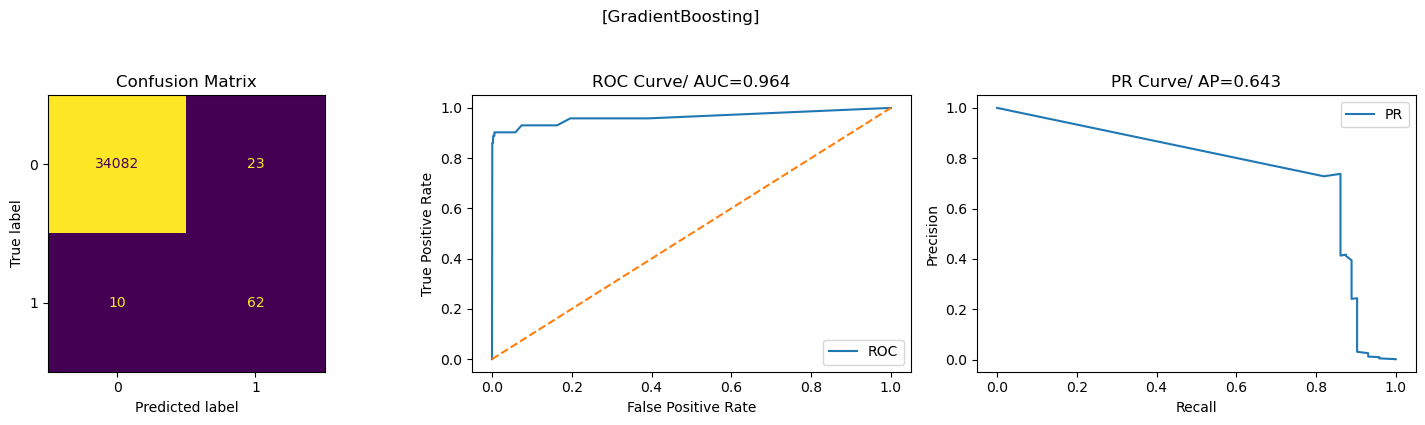


[Bagging] ROC-AUC: 0.9442 | PR-AUC: 0.8587 | F1: 0.8696
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     34105
           1     0.9091    0.8333    0.8696        72

    accuracy                         0.9995     34177
   macro avg     0.9544    0.9166    0.9347     34177
weighted avg     0.9995    0.9995    0.9995     34177



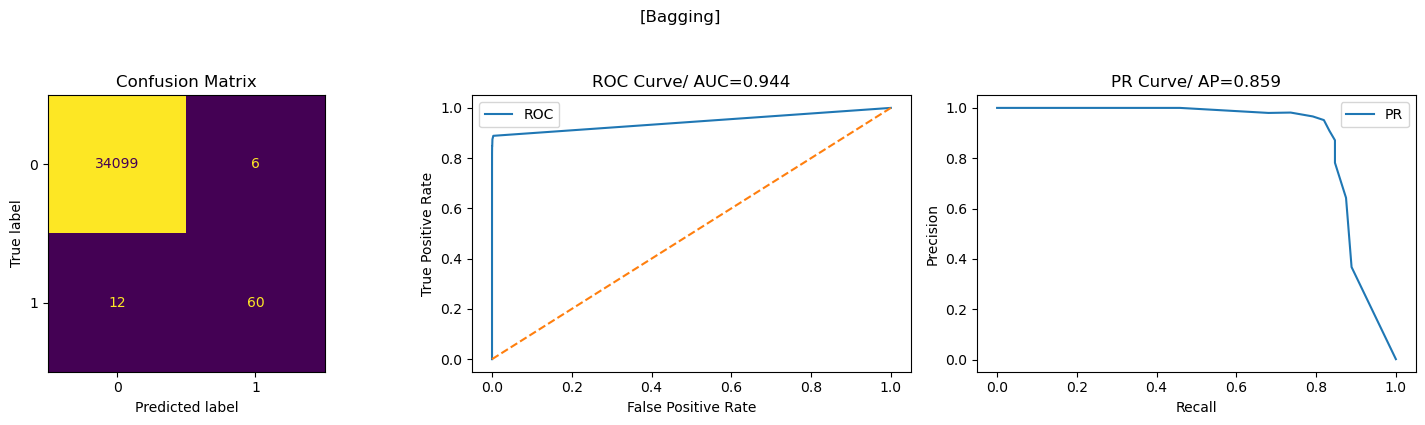


============= Baseline Leaderboard =============
               name   pr_auc  roc_auc       f1
        ExtraTrees 0.883834 0.969783 0.926471
      RandomForest 0.876529 0.949400 0.910448
               MLP 0.871458 0.988188 0.861538
           Bagging 0.858673 0.944200 0.869565
               KNN 0.846021 0.937383 0.854962
LogisticRegression 0.739777 0.982945 0.147895
         LinearSVC 0.731734 0.954453 0.717557
  GradientBoosting 0.643265 0.963733 0.789809
           SVC_RBF 0.594002 0.970138 0.537037
       BernoulliNB 0.579751 0.946968 0.759124
      DecisionTree 0.527771 0.867748 0.726027
        GaussianNB 0.099261 0.957761 0.130152


In [13]:
results = []

for name, clf, kind in models:
    base = pipe_map[kind]
    pipe = Pipeline(base.steps + [('clf', clf)])

    try:
        res = evaluate_model(name, pipe, X_train, y_train, X_valid, y_valid)
        results.append(res)
        plot_model_summary(y_true=y_valid, y_pred=res['y_pred'], y_proba=res['y_proba'],
                           title_prefix=name, roc_auc=res['roc_auc'],pr_auc=res['pr_auc'])
        
    except Exception as e:
        print(f'[{name}] failed with error: {e}')

leaderboard = pd.DataFrame(results).sort_values(['pr_auc', 'roc_auc'], ascending=False)[['name','pr_auc','roc_auc','f1']]
print('\n============= Baseline Leaderboard =============\n', leaderboard.to_string(index=False))

In [14]:
scoring = {'prauc': make_scorer(average_precision_score, needs_proba=True),
           'roc': make_scorer(roc_auc_score, needs_threshold=True)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sample_weight = compute_sample_weight(class_weight='balanced', y=y)
fit_params = {'clf__sample_weight': sample_weight}  

In [15]:
et = Pipeline(steps=[('block', tree_pipe),
                     ('clf', ExtraTreesClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1))])

et_search = {'clf__n_estimators': [300, 500, 800],
             'clf__max_depth': [None, 12, 16, 24],
             'clf__min_samples_split': [2, 5, 10, 20],
             'clf__min_samples_leaf': [1, 2, 4, 8],
             'clf__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.8],
             'clf__bootstrap': [False, True],
             'clf__class_weight': [None, 'balanced']}

et_rs = RandomizedSearchCV(et, et_search, n_iter=40, scoring=scoring, refit='prauc',
                           cv=cv, n_jobs=-1, verbose=1, random_state=42)

et_rs.fit(X, y)
print('[ET] best PR-AUC (CV):', et_rs.best_score_)
print('[ET] best params:', et_rs.best_params_)

best_et = et_rs.best_estimator_
tuned_et_res = evaluate_model('ExtraTrees_tuned', best_et, X_train, y_train, X_valid, y_valid)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[ET] best PR-AUC (CV): 0.8798080639517231
[ET] best params: {'clf__n_estimators': 800, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 0.5, 'clf__max_depth': 24, 'clf__class_weight': None, 'clf__bootstrap': False}

[ExtraTrees_tuned] ROC-AUC: 0.9670 | PR-AUC: 0.8840 | F1: 0.9118
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     34105
           1     0.9688    0.8611    0.9118        72

    accuracy                         0.9996     34177
   macro avg     0.9842    0.9305    0.9558     34177
weighted avg     0.9996    0.9996    0.9996     34177



In [26]:
et = Pipeline(steps=[('block', tree_pipe),
                     ('clf', ExtraTreesClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1))])

et_search = {'clf__n_estimators': [300, 500, 800],
             'clf__max_depth': [None, 12, 16, 24],
             'clf__min_samples_split': [2, 5, 10, 20],
             'clf__min_samples_leaf': [1, 2, 4, 8],
             'clf__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.8]}

ext_re = RandomizedSearchCV(et, et_search, n_iter=40, scoring=scoring, refit='prauc',
                           cv=cv, n_jobs=-1, verbose=1, random_state=42)

ext_re.fit(X, y)
print('[ET] best PR-AUC (CV):', ext_re.best_score_)
print('[ET] best params:', ext_re.best_params_)

best_ext = ext_re.best_estimator_
tuned_ext_res = evaluate_model('ExtraTrees_tuned', best_ext, X_train, y_train, X_valid, y_valid)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[ET] best PR-AUC (CV): 0.8769425599036339
[ET] best params: {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 0.8, 'clf__max_depth': 24}

[ExtraTrees_tuned] ROC-AUC: 0.9580 | PR-AUC: 0.8875 | F1: 0.9265
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9999     34105
           1     0.9844    0.8750    0.9265        72

    accuracy                         0.9997     34177
   macro avg     0.9921    0.9375    0.9632     34177
weighted avg     0.9997    0.9997    0.9997     34177



In [16]:
xgb_pipe = Pipeline([('block', preprocessor),  
                     ('clf', XGBClassifier(objective='binary:logistic', eval_metric='aucpr',
                                           tree_method='hist', random_state=42))])

xgb_search = {'clf__n_estimators': [600, 1200, 2000],
              'clf__max_depth': [4, 6, 8],              
              'clf__learning_rate': [0.02, 0.05, 0.1],
              'clf__subsample': [0.6, 0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              'clf__reg_lambda': [0.5, 1.0, 2.0],
              'clf__min_child_weight': [1.0, 2.0, 5.0]}

xgb_rs = RandomizedSearchCV(xgb_pipe, xgb_search, n_iter=40, scoring=scoring, 
                            refit='prauc', cv=cv, n_jobs=-1, random_state=42, verbose=1)

xgb_rs.fit(X, y)
print('[XGB] best PR-AUC (CV):', xgb_rs.best_score_)
print('[XGB] best params:', xgb_rs.best_params_)

best_xgb = xgb_rs.best_estimator_
tuned_xgb_res = evaluate_model('XGB_tuned', best_xgb, X_train, y_train, X_valid, y_valid)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[XGB] best PR-AUC (CV): 0.8853096054974714
[XGB] best params: {'clf__subsample': 0.8, 'clf__reg_lambda': 0.5, 'clf__n_estimators': 600, 'clf__min_child_weight': 2.0, 'clf__max_depth': 4, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 1.0}

[XGB_tuned] ROC-AUC: 0.9755 | PR-AUC: 0.8929 | F1: 0.8939
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     34105
           1     0.9833    0.8194    0.8939        72

    accuracy                         0.9996     34177
   macro avg     0.9915    0.9097    0.9469     34177
weighted avg     0.9996    0.9996    0.9996     34177



In [17]:
from lightgbm import early_stopping, log_evaluation

lgb = Pipeline(steps=[('block', tree_pipe),
                      ('clf', LGBMClassifier(objective='binary', n_estimators=1000, learning_rate=0.05, num_leaves=63,
                                             subsample=0.8, subsample_freq=1, feature_fraction=0.8, class_weight='balanced',
                                             reg_lambda=1.0, random_state=42, n_jobs=-1))])

param_dist_lgb = {'clf__n_estimators': randint(600, 800),
                  'clf__num_leaves': randint(60, 80),
                  'clf__learning_rate': uniform(0.02, 0.06), 
                  'clf__min_child_samples': randint(60, 80),  
                  'clf__subsample': uniform(0.6, 0.4),     
                  'clf__feature_fraction': uniform(0.5, 0.5), 
                  'clf__reg_lambda': uniform(0.0, 2.5) }

rs_lgb = RandomizedSearchCV(estimator=lgb, param_distributions=param_dist_lgb, n_iter=30,  cv=cv, 
                            scoring=scoring, refit='prauc', n_jobs=-1, verbose=1, random_state=42)

rs_lgb.fit(X, y)
print('[LGBM-RAND] best PR-AUC (CV):', rs_lgb.best_score_)
print('[LGBM-RAND] best params:', rs_lgb.best_params_)

best_lgb = rs_lgb.best_estimator_
best_lgb.set_params(clf__n_estimators=3000)  
callbacks = [early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
best_lgb.fit(X_train, y_train, clf__eval_set=[(X_valid, y_valid)],  clf__eval_metric='average_precision', clf__callbacks=callbacks)
tuned_lgb_res = evaluate_model('LGBM_tuned', best_lgb, X_train, y_train, X_valid, y_valid)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] feature_fraction is set=0.5480882755457104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480882755457104
[LightGBM] [Warning] feature_fraction is set=0.5480882755457104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480882755457104
[LightGBM] [Info] Number of positive: 360, number of negative: 170523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 170883, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LGBM-RAND] best PR-AUC (CV): 0.8873840770091892
[LGBM-RAND] best params: {'clf__feature_fraction': 0.5480882755457104, 'clf__learning_r

In [18]:
# def objective(trial):
#     params = {'n_estimators': trial.suggest_int('n_estimators', 600, 1800, step=200),
#               'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.12, log=True),
#               'num_leaves': trial.suggest_int('num_leaves', 31, 255, step=16),
#               'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
#               'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#               'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#               'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 3.0),
#               'random_state': 42,
#               'n_jobs': -1,
#               'class_weight': 'balanced'}
#     model = Pipeline(steps=[('block', tree_pipe),('clf', LGBMClassifier(**params))])

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     pr_scores = []
#     for tr_idx, va_idx in skf.split(X, y):
#         X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
#         y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
#         model.fit(X_tr, y_tr)
#         y_proba = model.predict_proba(X_va)[:,1]
#         pr_scores.append(average_precision_score(y_va, y_proba))
#     return float(np.mean(pr_scores))

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# print('Best PR-AUC (CV):', study.best_value)
# print('Best params:', study.best_params)

In [ ]:
# rows = []
# for name, gs in [('ExtraTrees', et_rs),('XGBoost', xgb_rs),('LightGBM', lgb_rs)]:
#     rows.append({'model': name, 'best_pr_auc_cv': gs.best_score_, 'best_params': gs.best_params_})

# leaderboard_cv = pd.DataFrame(rows).sort_values('best_pr_auc_cv', ascending=False)
# print(leaderboard_cv) 

In [27]:
X_test_features = X_test.reindex(columns=best_lgb.feature_names_in_, fill_value=0)
ext_prob = best_ext.predict(X_test_features)

submission = pd.DataFrame({'id': X_test['id'], 'Class': ext_prob})
submission.to_csv('./modulabs-ds5-credit-card-fraud-detection/sample_submission4.csv', index=False)